# Using the O'Neil (2019) Observation-based Priors

by Sarah Blunt and Clarissa R. Do Ó (2024)


### Background on Observable-base Priors 

Observable-based priors are a different set of priors from the standard "parameter" priors that most orbit fitting codes (including orbitize!) use. Here, rather than placing uniform priors on orbital parameters such as eccentricity and periastron passage, uniform priors are placed on the "observables" of the orbit (which are linearly related to the measured positions of the companion).  The idea behind these priors is that there is an equal probability (i.e., uniform probability) of obtaining observations in the regions of parameter space that are possible to observe. For that reason, observable priors present uniformity in the orbital observables, which can be transformed back to orbital parameters.

The paper where these priors are introduced is  <a href = "https://ui.adsabs.harvard.edu/abs/2019AJ....158....4O/abstract"> O'Neil et al 2019</a>, so if you use this functionality please cite that paper.

Note: The observable-based priors are set up in a different orbital basis from orbitize!'s basis. The main difference is that they use period P rather than semi-major axis a and periastron passage epoch (in years) rather than the unitless parameter $\tau$.


### Initial Set up

First, we import orbitize's driver and the "priors" functionality:


In [1]:
# TODO (clarissa): write tutorial intro

import numpy as np
import os
import multiprocessing as mp

from orbitize import read_input, priors, system, sampler, DATADIR

### Set up MCMC run

Now, we will set up our MCMC run. Here, we will use the object HD 206893 B as an example orbit for this tutorial. 

We begin but providing the astrometry data in CSV format and the system's mass and parallax. For this tutorial, and in general, one should use RA and Dec astrometry measurements rather than separation/P.A..

We also set up the number of temps, walkers and threads for our MCMC run and set up the driver object.

In [2]:
filename = "{}/hd206893b.csv".format(orbitize.DATADIR)

# system parameters
num_secondary_bodies = 1
system_mass = 1.35  # [Msol]
plx = 24.5272375  # [mas]

data_table = read_input.read_file(input_file)
mtot = 1.0
plx = 10.0

# TODO (sarah): note that the fitting basis choice here is required (can't fit in any other orbitize! basis)
# if we want to use obspriors
mySystem = system.System(
    1, data_table, mtot, plx, mass_err=0, plx_err=0, fitting_basis="ObsPriors"
)

print("We are fitting using this orbital basis: {}".format(mySystem.param_idx))

We are fitting using this orbital basis: {'per1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tp1': 5, 'plx': 6, 'mtot': 7}


Let's check if the data is being read correctly!

In [7]:
my_driver.system.data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant12_corr,quant_type,instrument
float64,int64,float64,float64,float64,float64,float64,bytes5,bytes5
57298.0,1,-253.72,2.98,92.35,2.85,nan,radec,defrd
57606.0,1,-236.63,9.77,127.94,9.18,nan,radec,defrd
57645.0,1,-234.52,1.79,123.39,1.03,nan,radec,defrd
57946.0,1,-210.76,1.94,152.09,1.88,nan,radec,defrd
58276.0,1,-167.49,1.61,180.87,16.97,nan,radec,defrd
58287.0,1,-177.67,1.67,174.6,1.67,nan,radec,defrd
58365.0,1,-165.7,3.28,185.33,3.66,nan,radec,defrd
58368.0,1,-170.38,2.52,185.94,2.74,nan,radec,defrd
58414.0,1,-161.64,13.6,176.21,14.31,nan,radec,defrd


## Modify Priors

Define the priors on `sma`, `ecc`, `tau`, `plx`, and `mtot` to be the O'Neil observation-based prior.

In [8]:
# convert input sep/PA measurements to RA/decl
ra = np.array(my_driver.system.data_table["quant1"])
ra_err = np.array(my_driver.system.data_table["quant1_err"])
dec = np.radians(np.array(my_driver.system.data_table["quant2"]))
pa_err = np.radians(np.array(my_driver.system.data_table["quant2_err"]))
[]

#ra_err = np.sqrt((np.cos(pa) * sep_err) ** 2 + (sep * np.sin(pa) * pa_err) ** 2)
#dec_err = np.sqrt((np.sin(pa) * sep_err) ** 2 + (sep * np.cos(pa) * pa_err) ** 2)

ra_err = mySystem.data_table["quant1_err"]
dec_err = mySystem.data_table["quant1_err"]
epochs = np.array(mySystem.data_table["epoch"])

# define the `ObsPrior` object
my_obsprior = priors.ObsPrior(ra_err, dec_err, epochs, mtot, period_lims=(0.01, 1000))

# set the priors on `sma`, `ecc`, `tau`, `mtot`, and `plx` to point to this object
for i in [
    mySystem.param_idx["per1"],
    mySystem.param_idx["ecc1"],
    mySystem.param_idx["tp1"],
]:
    mySystem.sys_priors[i] = my_obsprior

mySystem.sys_priors

AttributeError: module 'orbitize.priors' has no attribute 'ObsPrior'

### Run MCMC!

Let's run this orbit fit!

Starting Burn in


/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/Users/bluez3303/Documents/GitHub/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(n

10/10 steps of burn-in complete
Burn in complete. Sampling posterior now.
10/10 steps completed
Run complete


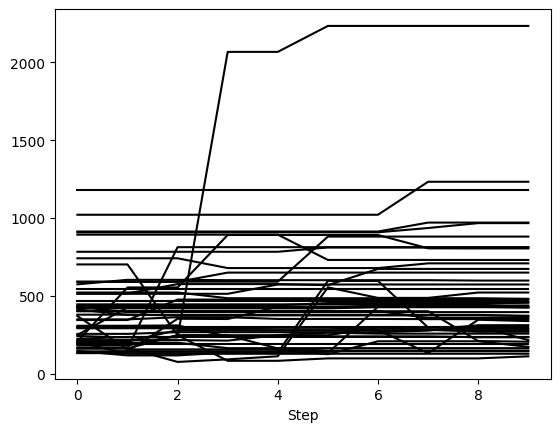

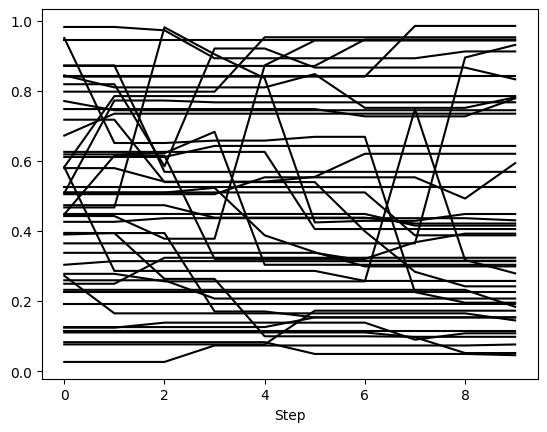

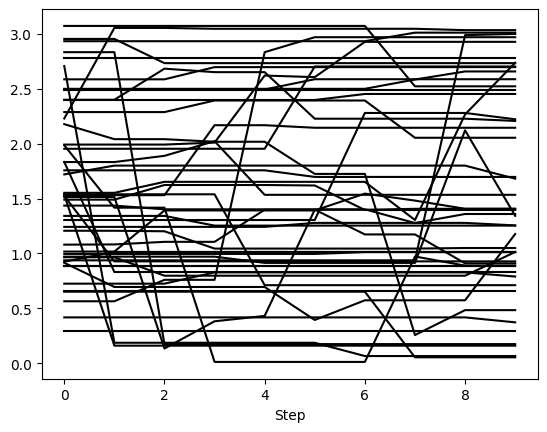

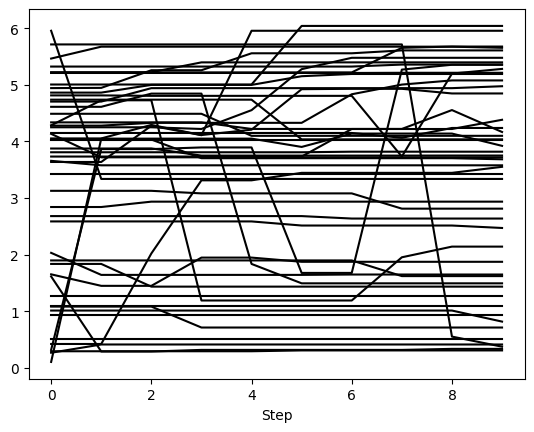

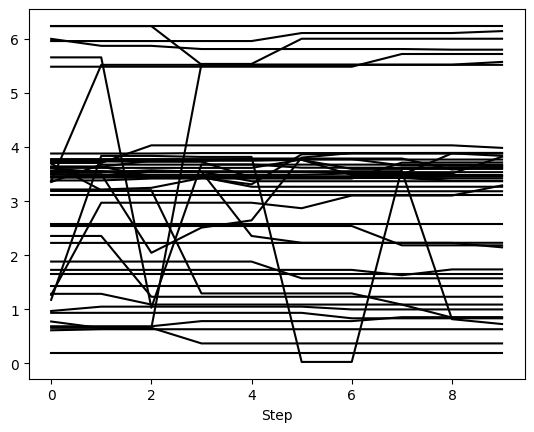

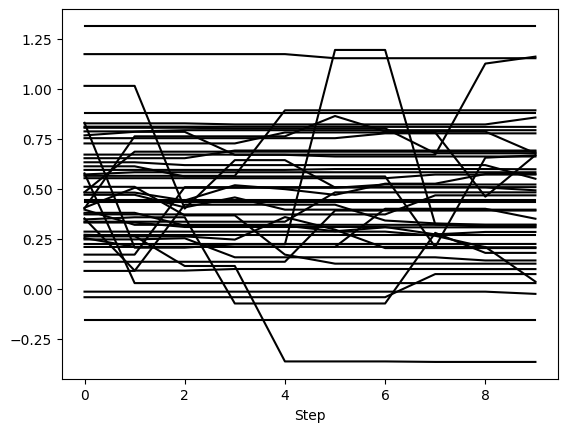

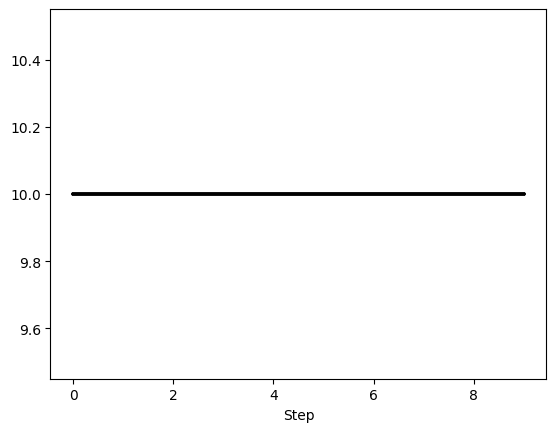

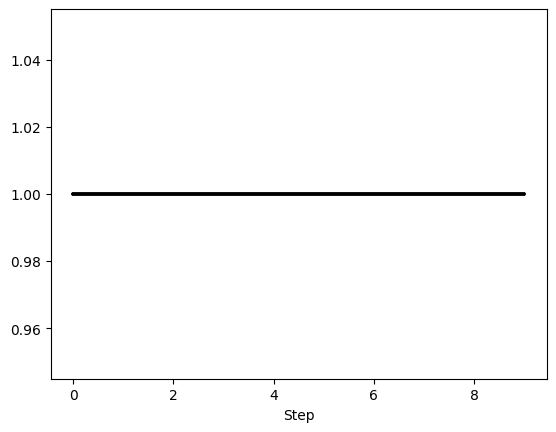

In [4]:
# create an MCMC object using our newly modified System object
num_temps = 5
num_walkers = 50
num_threads = mp.cpu_count()
myMCMC = sampler.MCMC(
    mySystem, num_temps=num_temps, num_walkers=num_walkers, num_threads=num_threads
)

n_steps_per_walker = 10
n_burn_steps = 10

myMCMC.run_sampler(n_steps_per_walker * num_walkers, burn_steps=10, examine_chains=True)

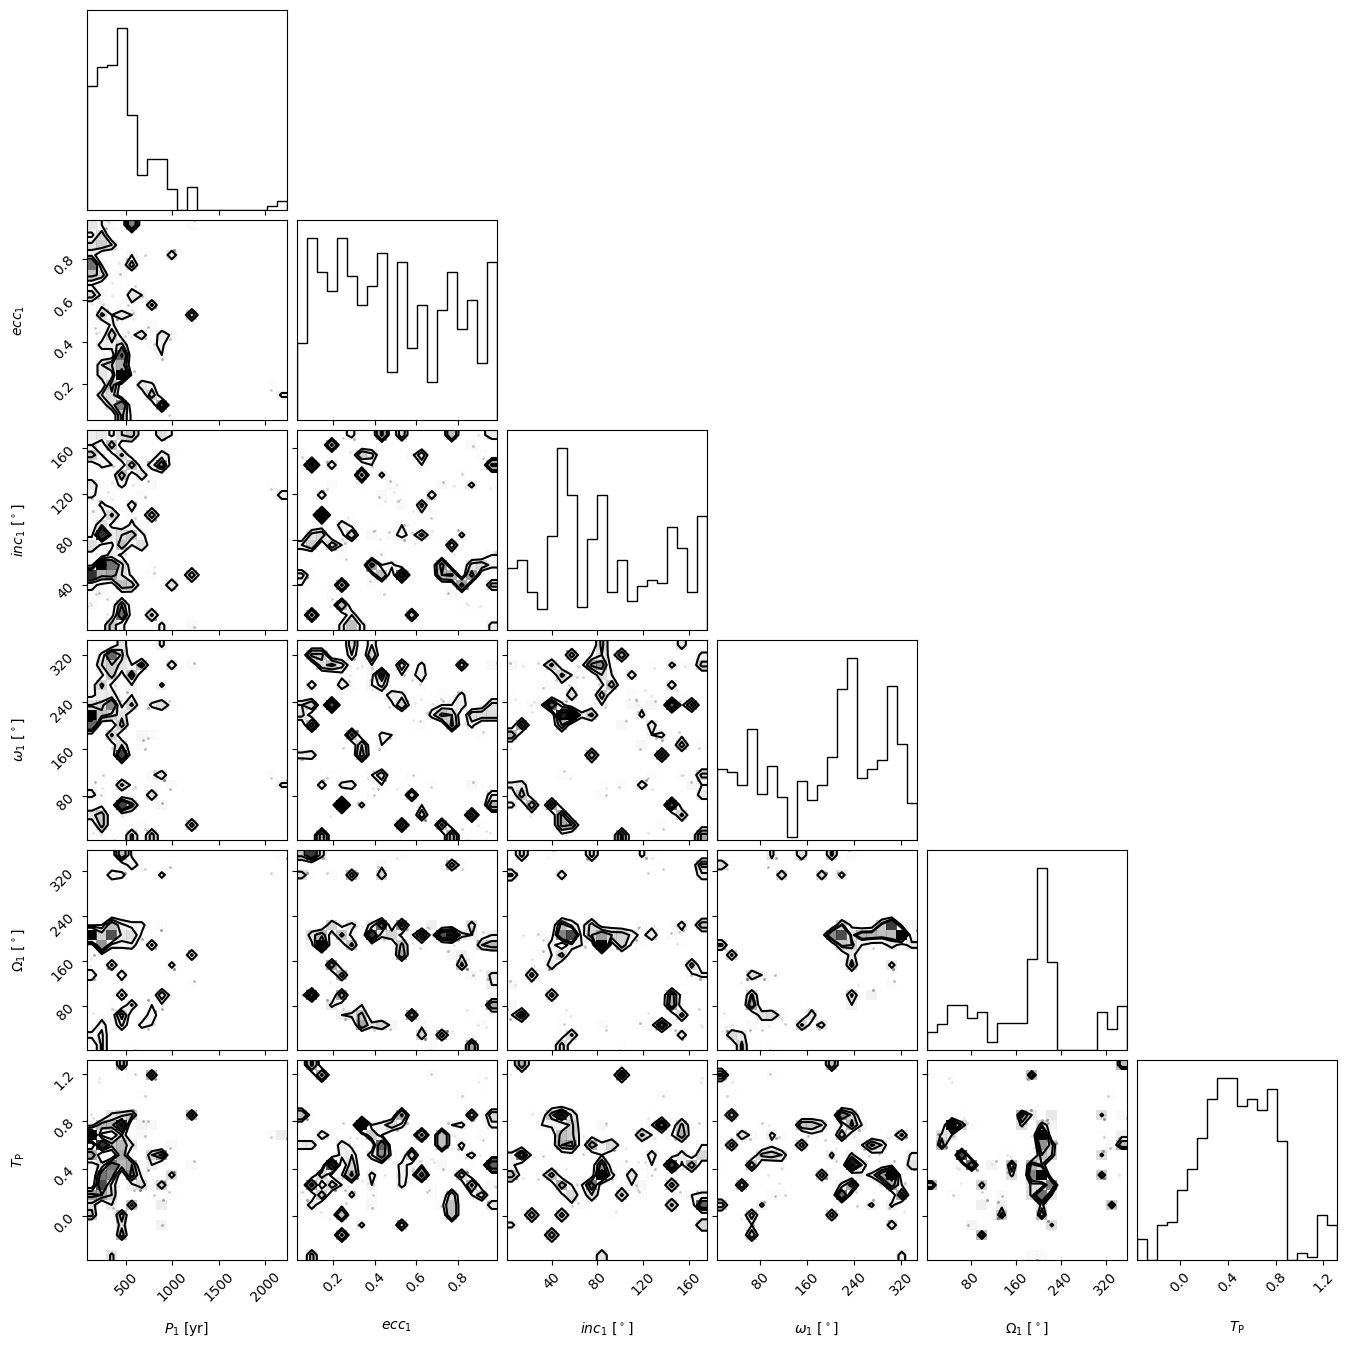

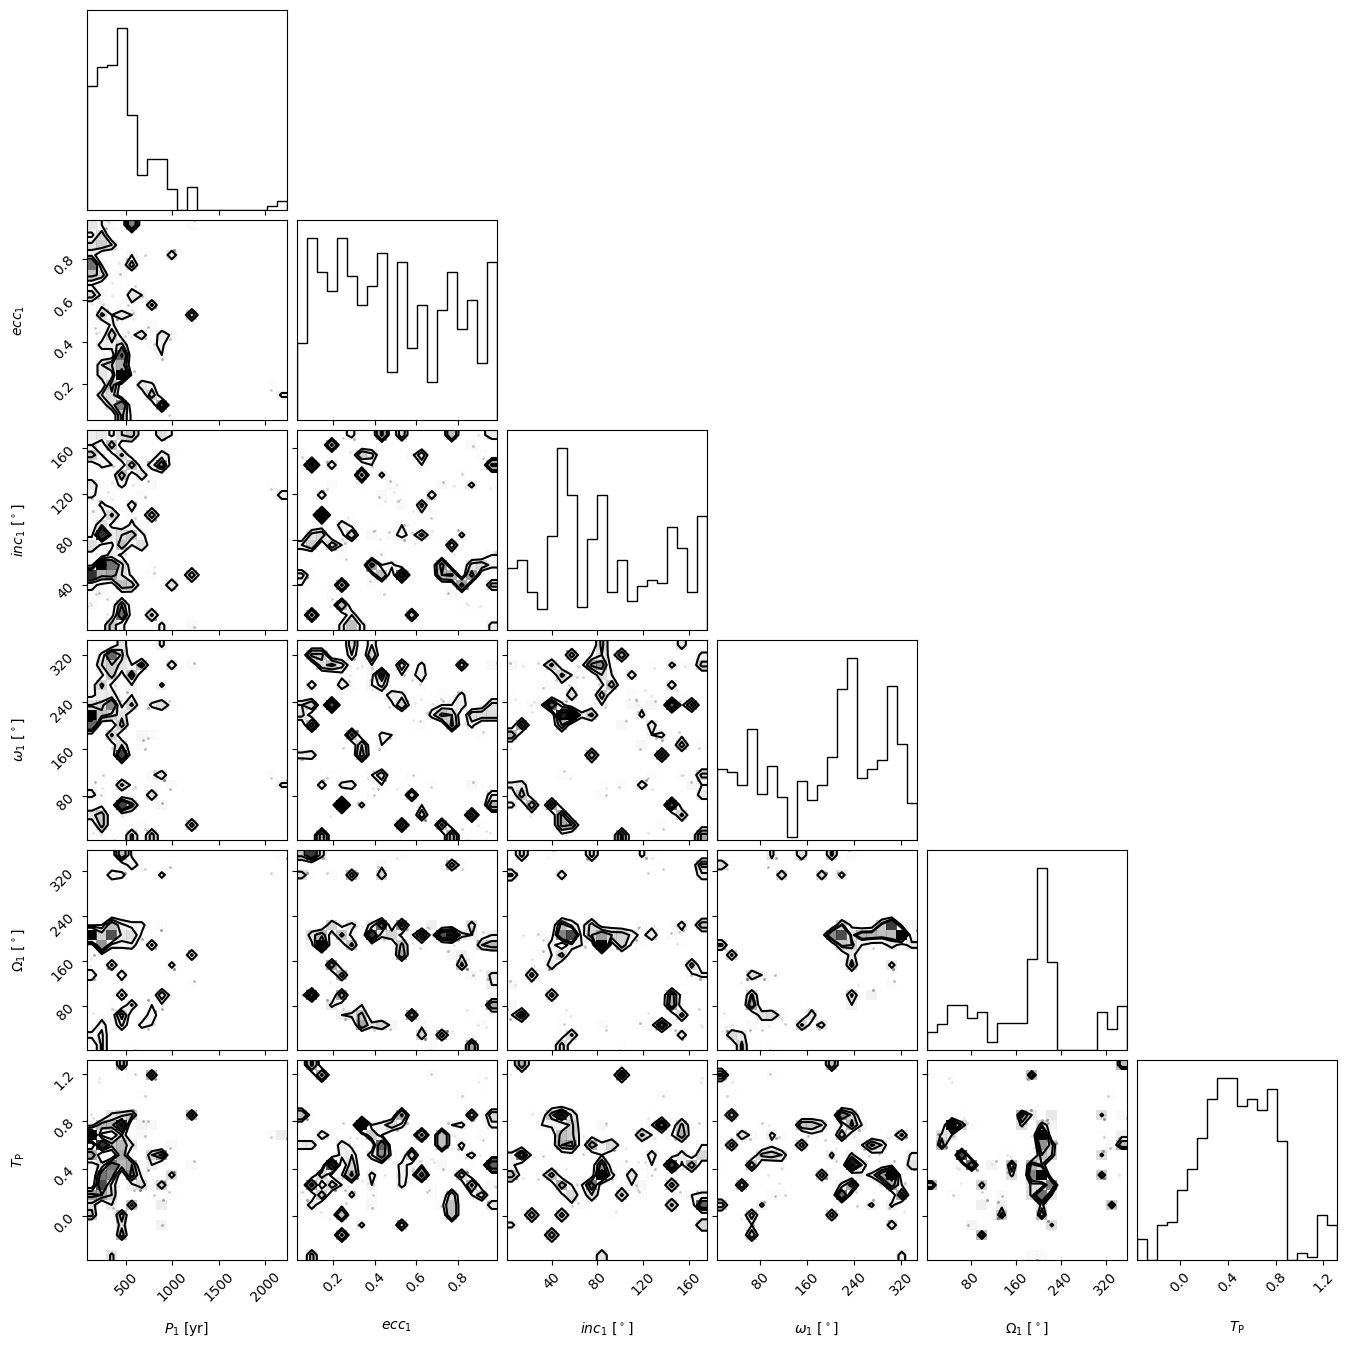

In [5]:
my_corner = myMCMC.results.plot_corner()
my_corner